<a href="https://colab.research.google.com/github/aegorfk/Data-science-using-Python/blob/master/Working_with_geo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание в команду продуктовой аналитики, Gett. Ляпина Екатерина

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

**0.** Подготовка данных

In [1]:
!pip install pydrive
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#File is here
#https://drive.google.com/file/d/1-_Z8HOscXw8ddtW6RGMTwWravA450Sqv/view?usp=sharing
fileId = '1-_Z8HOscXw8ddtW6RGMTwWravA450Sqv'

In [2]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

!ls -lah

Extracted zip file 1-_Z8HOscXw8ddtW6RGMTwWravA450Sqv.zip
total 9.3M
drwxr-xr-x 1 root root 4.0K Jul  3 11:52  .
drwxr-xr-x 1 root root 4.0K Jul  3 08:39  ..
-rw-r--r-- 1 root root 2.5K Jul  3 08:49  adc.json
drwxr-xr-x 1 root root 4.0K Jul  3 08:49  .config
-rw-r--r-- 1 root root 8.7M Jul  3 11:52  data_offers.csv
-rw-r--r-- 1 root root 559K Jul  3 11:52  data_orders.csv
drwxr-xr-x 2 root root 4.0K Jul  3 08:49  __MACOSX
-rw-r--r-- 1 root root  12K Jul  3 11:52 'Matching Home Assignment for Candidates.ipynb'
drwxr-xr-x 1 root root 4.0K Jun 18 16:14  sample_data


In [0]:
import pandas as pd
data_orders = pd.read_csv('data_orders.csv')
data_offers = pd.read_csv('data_offers.csv')

data_orders['order_datetime'] =  pd.to_datetime(data_orders['order_datetime']) #format='%Y-%m-%d %H:%M:%S'

In [4]:
data_orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,2019-07-03 18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,2019-07-03 20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,2019-07-03 12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,2019-07-03 13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,2019-07-03 21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [5]:
data_orders["order_status_key"] = data_orders['order_status_key'].astype('object')
data_orders["is_driver_assigned_key"] = data_orders['is_driver_assigned_key'].astype('object')
data_orders.dtypes

order_datetime                   datetime64[ns]
origin_longitude                        float64
origin_latitude                         float64
m_order_eta                             float64
order_gk                                  int64
order_status_key                         object
is_driver_assigned_key                   object
cancellations_time_in_seconds           float64
dtype: object

In [6]:
print(data_orders.isnull().sum())

order_datetime                      0
origin_longitude                    0
origin_latitude                     0
m_order_eta                      7902
order_gk                            0
order_status_key                    0
is_driver_assigned_key              0
cancellations_time_in_seconds    3409
dtype: int64


In [7]:
data_orders["order_status_key"].value_counts()

4    7307
9    3409
Name: order_status_key, dtype: int64

In [8]:
data_offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [9]:
print(data_offers.isnull().sum())

order_gk    0
offer_id    0
dtype: int64


**1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [0]:
data_orders["category"] = data_orders["order_status_key"].astype(str) \
                + data_orders["is_driver_assigned_key"].astype(str)
data_orders["category"] = data_orders["category"].astype(int)

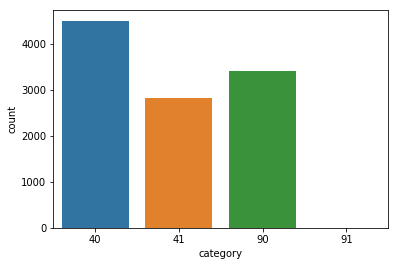

In [11]:
import seaborn as sns
ax = sns.countplot(x="category", data=data_orders)

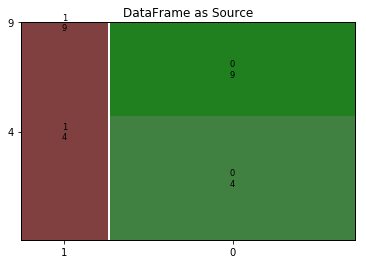

In [12]:
from statsmodels.graphics.mosaicplot import mosaic
import matplotlib.pyplot as plt
mosaic(data_orders, ['is_driver_assigned_key', 'order_status_key'], title = 'DataFrame as Source')
plt.show()

Проанализируйте полученный график - в какой категории наибольшое количество заказов?

**Большее количество заказов в категории "заказ был отменен клиентом, но водитель еще не был назначен"**

**2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?
В какие часы фейлов больше всего? Чем это можно объяснить?

**Больше всего отмен в 8 утра. Это может быть связано с тем, что люди примерно в это время собираются на работу, заказывают транспорт, а потом находят альтернативы.**

**Можно отметить, что в пиковые часы (с 20 до 1 часа) доля заказов, отмененных самим клиентом, но когда водитель не назначен (категория 40) значительно больше категории 41, то есть когда водитель уже успел был назначить. Не сказать, что это прямо аномальная разница, но она довольно значительная.**

<Figure size 1152x720 with 0 Axes>

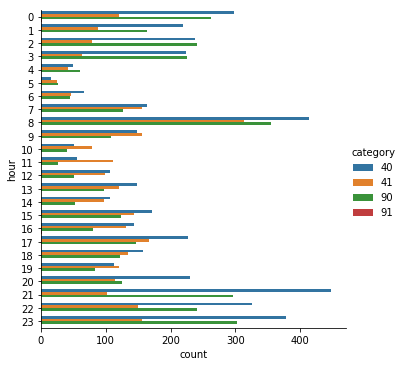

In [13]:
#General counts
plt.figure(figsize = (16, 10))
data_orders["hour"] = data_orders["order_datetime"].dt.hour
sns.catplot(y = "hour", hue = "category", kind = "count", data = data_orders)

Orders in a category 9    3
Name: order_status_key, dtype: int64


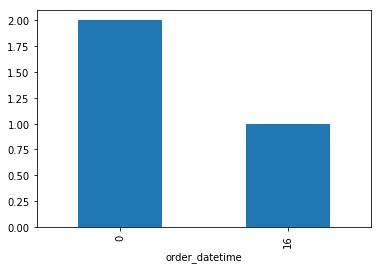

In [14]:
data_orders_91 = data_orders.loc[data_orders["category"] == 91]
print("Orders in a category " + str(data_orders_91["order_status_key"].value_counts()))
data_orders_91.order_datetime.groupby(data_orders_91["order_datetime"].dt.hour).count().plot(kind = "bar")
# This category is extremelly rare, so it might be a technical one

**3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

**Отсуствие значимых аномалий, пропорции категорий примерно сохраняются.**

In [0]:
import numpy as np

df = data_orders[np.isfinite(data_orders['cancellations_time_in_seconds'])]

Q1 = df.cancellations_time_in_seconds.quantile(0.25)
Q3 = df.cancellations_time_in_seconds.quantile(0.75)
IQR = Q3 - Q1

df = df[(df['cancellations_time_in_seconds'] < (Q1 - 1.5 * IQR))  \
     |  (df['cancellations_time_in_seconds'] > (Q3 + 1.5 * IQR))]

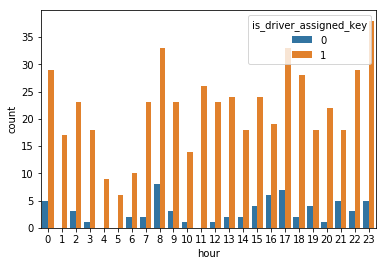

In [16]:
ax = sns.countplot(x="hour", hue="is_driver_assigned_key", data = df)

**4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

**Можно увидеть пики в 8, 17 часов, связанные с маятниковой миграцией, а также характерные (но не такие сильные) пики спроса с 21 до 0 часов - возможно, ночная жизнь. Повышенное ожидание может быть связано с повышенным спросом на транспортные услуги в это время суток.**

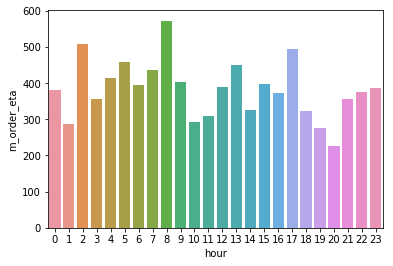

In [17]:
eta = df.groupby('hour').mean().reset_index()

ax = sns.barplot(x = "hour", y = "m_order_eta", data = eta)

*Место для ответа*

**5.** Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

**Нет такой колонки в предоставленных данных, но я создала ее из второго набора данных. Наблюдается малое количество показа водителям в 4-5 часов ночи, что может быть связано с малым количество активных водителей в это время (водители спят). Также есть просадки по показам в 10 утра и 19 вечера. Это может быть связанно например с желанием водителей сделать перерыв после пиковых часов спроса, но может быть из-за того, что водители загруженны еще пиковыми заказами.**

In [0]:
offers = pd.DataFrame(data_offers["order_gk"].value_counts()).reset_index()
offers.columns = ["order_gk", "drivers_offered"]
data_orders = pd.merge(data_orders, offers, how = 'left', on = 'order_gk')
data_orders['drivers_offered'] = data_orders['drivers_offered'].fillna(0)

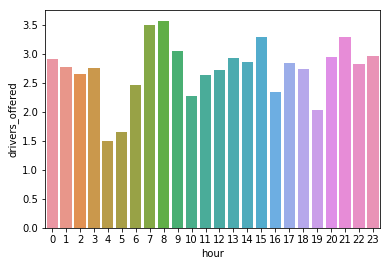

In [19]:
offers = data_orders.groupby('hour').mean().reset_index()
ax = sns.barplot(x = "hour", y = "drivers_offered", data = offers)

**6*.** Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [0]:
#!pip install h3 folium
#given a latitude/longitude point, find the index of the containing H3 cell at a particular resolution

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)   
from h3 import h3
import folium

def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=15, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m
    

def visualize_polygon(polyline, color):
    polyline.append(polyline[0])
    lat = [p[0] for p in polyline]
    lng = [p[1] for p in polyline]
    m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
    m.add_child(my_PolyLine)
    return m

In [21]:
#how many values account to 80%
data_orders['hexagons'] = data_orders.apply(lambda x: h3.geo_to_h3(x.origin_longitude, x.origin_latitude, 8), axis=1)
hexagons = pd.DataFrame(data_orders['hexagons'].value_counts()).reset_index().values
counting_value  = int(round(0.8 * data_orders["order_gk"].shape[0], 0))
print("Our 80% is " + str(counting_value) + " offers." )

Our 80% is 8573 offers.


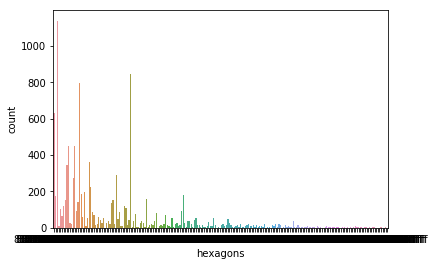

In [22]:
ax = sns.countplot(x = "hexagons", data = data_orders)

In [27]:
counting = 0
counting_hex = 0
names = []
for x in range(0, hexagons.shape[0]):
  if counting <= counting_value:
    counting = counting + hexagons[x][1]
    counting_hex = counting_hex + 1
    names.append(hexagons[x][0])

print("Количество гексагонов " + str(counting_hex))

Количество гексагонов 36


In [25]:
#visualise 80%
m = visualize_hexagons(names, color="purple")
m

In [26]:
#The biggest one:
#hexagons[:,0][0]
m = visualize_hexagons(hexagons[:,0][0], color="purple")
m

Ответ:
- Минимальное количество гексагонов, которое вмещает в себя 80% отмененных заказов - **36** 
- Количество гексагонов, которые вмещают ровно 80% отмененных заказов:

In [0]:
#def subsetsum(array, num):
#    if sum(array) == num:
#        return array
#    if len(array) > 1:
#        for subset in (array[:-1], array[1:]):
#            result = subsetsum(subset, num)
#            if result is not None:
#                return result
#subsetsum(hexagons[:,1], counting_value)